<a href="https://colab.research.google.com/github/Pimateos/Deep-Learning/blob/master/Pr%C3%A1cticaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1: Cuestionario (2.5 puntos)

### 1.1 *(0.5 puntos)* Explicar por qué es preferible hacer np.dot(X, Y), donde X e Y son arrays bidimensionales, que ejecutar un triple bucle con el algoritmo básico de la multiplicación de matrices.

Porque numpy calcula en paralelo las matrices en lugar del metodo clasico que se itera.

### 1.2 *(0.5 puntos)* Explicar qué ventajas nos aporta utilizar un grafo de computación a la hora de entrenar redes neuronales.

Sabemos el orden que tienen las operaciones y si son compatibles.

Mas velocidad de ejecución.

Nos permite poder establecer el punto desde el cual queremos computar. Ademas de establecer paralelismos. Esto nos ayuda a ejecutar en entornos distribuidos y/o GPUs.

Los frameworks modernos tienen operaciones embebidas en los nodos de los grafos, por ejemplo, el backward propagation.  Esto lo hacen automaticamente y es muy importante en redes muy grandes(autodiferenciación)

### 1.3 *(0.5 puntos)* Hemos visto cómo con TensorFlow es posible añadir una operación de optimización (como *tf.train.GradientDescentOptimizer*) y aplicar con ésta la minimización de la función de pérdida. Explicar cómo afecta esto al grafo de computación y cuál es su relación con el entrenamiento de una red neuronal.

Gradient Descent Optimizer nos permite calcular el array cuando tenemos variables variables minimizando el error de las mismas al valor que establezcamos, pero computandola optimizando el calculo de matrices.

### 1.4 *(0.5 puntos)* ¿Qué diferencias hay entre grafos estáticos y grafos dinámicos?




Los grafos estáticos se calculan antes de ejecutar el código. Mientras que los grafos dinámicos se calculan mientras se estan ejecutando. Pytorch los calcula dinámicamente. Mientras que Tensorflow estáticamente en versiones antiguas. A partir de Tensorflow 2.0 se calculan por defecto dinámicamente y se puede cambiar a forma estática.

Los grafos dinamicos son buenos para experimentación. Sin embargo, para producción son mejores los estáticos.

### 1.5 *(0.5 puntos)* Algunas ops en redes neuronales tienen un comportamiento diferente durante *training time* (cuando entrenamos la red) que durante *inference time* (cuando utilizamos la red ya entrenada). Da un ejemplo de una operación usada en redes neuronales de este tipo y explicar la diferencia en ejecución. ¿Qué consecuencias tiene esto en relación al grafo de computación?

Dropout se utiliza para prevenir el overfitting. No teniendo en cuenta aleatoriamente una neurona. Consiguiendo con su introduccion en el entrenamiento, modelos mas robustos.

En la parte de inferencia no tendria sentido utilizar esta técnica, ya que, ya tenemos entrenada la red y no tendria sentido meter un componente aleatorio en la predicción también. Porque la salida nos daria una predicción aleatoria.


# Parte 2: Laboratorio (7.5 puntos)

---



En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el clásico dataset de MNIST. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)


In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [91]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


## Entregable

Utilizando Convolutional Neural Networks con TensorFlow (ya sea tf.keras, TensorFlow Eager, o TensorFlow tradicional), entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **88%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

El entregable (en formato .ipynb, aunque puede apoyarse con un archivo pdf) tiene que contener los siguientes elementos:

**1 (1.5 puntos): Implementación con una red neuronal clásica**. Implementar primero un modelo feed-forward clásico, sin convoluciones. Mostrar código y  resultados de entrenamiento y accuracy en el test set.



In [92]:
print(X.shape)
print(X_t.shape)

(18992, 64, 64, 3)
(890, 64, 64, 3)


In [0]:
def plot_history(history):
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras import backend as K


In [0]:
batch_size = 32
num_classes = 18
epochs = 20



In [96]:
# the data, split between train and test sets
img_rows=64
img_cols=64
if K.image_data_format() == 'channels_first':
    x_train = X.reshape(X.shape[0], 1, img_rows, img_cols)
    x_test = X_t.reshape(X_t.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = X.reshape(X.shape[0], img_rows, img_cols,3)
    x_test = X_t.reshape(X_t.shape[0], img_rows, img_cols,3)
    input_shape = (img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train= y
y_test=y_t
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (18992, 64, 64, 3)
18992 train samples
890 test samples


In [97]:
print(64*64*3)
print(input_shape)
print(x_test.shape)

12288
(64, 64, 3)
(890, 64, 64, 3)


In [98]:
model = Sequential()
model.add(Dense(3, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 64, 64, 3)         12        
_________________________________________________________________
dropout_46 (Dropout)         (None, 64, 64, 3)         0         
_________________________________________________________________
dense_65 (Dense)             (None, 64, 64, 512)       2048      
_________________________________________________________________
dropout_47 (Dropout)         (None, 64, 64, 512)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_66 (Dense)             (None, 18)                37748754  
Total params: 37,750,814
Trainable params: 37,750,814
Non-trainable params: 0
________________________________________________________________

Train on 18992 samples, validate on 890 samples
Epoch 1/20
18992/18992 [==============================] - 219s 12ms/step - loss: 4.4603 - acc: 0.3718 - val_loss: 1.7693 - val_acc: 0.4989
Epoch 2/20
18992/18992 [==============================] - 216s 11ms/step - loss: 1.5078 - acc: 0.5785 - val_loss: 1.6404 - val_acc: 0.5292
Epoch 3/20
18992/18992 [==============================] - 217s 11ms/step - loss: 1.3222 - acc: 0.6325 - val_loss: 1.4097 - val_acc: 0.6022
Epoch 4/20
18992/18992 [==============================] - 217s 11ms/step - loss: 1.1916 - acc: 0.6705 - val_loss: 1.3522 - val_acc: 0.5831
Epoch 5/20
18992/18992 [==============================] - 216s 11ms/step - loss: 1.0850 - acc: 0.6993 - val_loss: 1.5002 - val_acc: 0.5449
Epoch 6/20
18992/18992 [==============================] - 216s 11ms/step - loss: 0.9967 - acc: 0.7269 - val_loss: 1.0815 - val_acc: 0.6798
Epoch 7/20
18992/18992 [==============================] - 219s 12ms/step - loss: 0.9194 - acc: 0.7434 - val_loss: 1.21

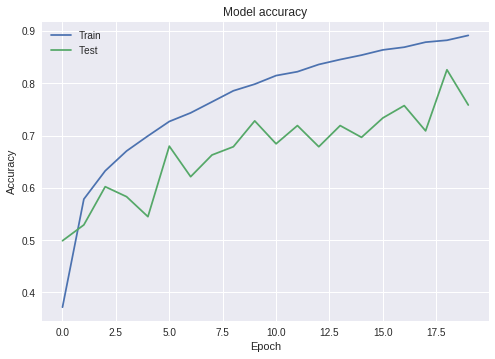

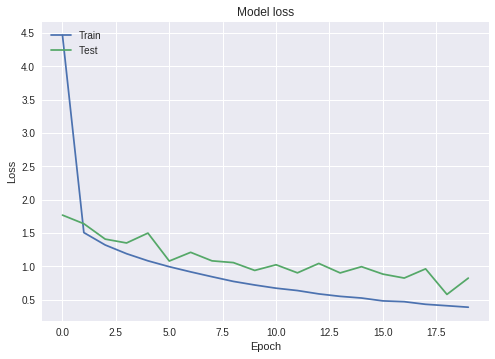

In [99]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

**2 (4.5 puntos): Implementación con CNNs**. Implementar una arquitectura CNN que consiga un 88% de accuracy en el test set. Mostrar código y resultados de entrenamiento y accuracy en el test set. Explicar brevemente la arquitectura utilizada y las pruebas realizadas.



# Implementacion con CNN

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer
from keras.preprocessing import image
import numpy as np
import os
image_height = 64
image_width = 64

In [150]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [166]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 18
epochs = 12

img_rows=64
img_cols=64
if K.image_data_format() == 'channels_first':
    x_train = X.reshape(X.shape[0], 3, img_rows, img_cols)
    x_test = X_t.reshape(X_t.shape[0],3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = X.reshape(X.shape[0], img_rows, img_cols,3)
    x_test = X_t.reshape(X_t.shape[0], img_rows, img_cols,3)
    input_shape = (img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train= y
y_test=y_t
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


input_shape=(64,64,3)







x_train shape: (18992, 3, 64, 64)
18992 train samples
890 test samples


In [170]:
x_train.shape

(18992, 3, 64, 64)

In [171]:
x_test.shape

(890, 3, 64, 64)

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import os
import sys
import tarfile
import numpy as np
img_width, img_height = 64, 64
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [189]:

from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])


def create_aug_gen(in_gen):

    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255*in_x, in_y,
                             batch_size=in_x.shape[0])
        x, y = next(g_x)

        yield x/255.0, y

train_gen = 
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

NameError: ignored

In [187]:
# Initialising the CNN
predator = Sequential()
# Step 1 - Convolution
predator.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_height, image_width, 3)))
# Step 2 - Pooling
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
predator.add(Conv2D(256, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fourth convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fifth convolutional layer
predator.add(Conv2D(64, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
predator.add(Flatten())    #flattens the 3D image array to a single row array
# Step 4 - Full connection
predator.add(Dense(units=18, activation="relu"))
predator.add(Dense(units=18, activation="softmax"))   #output layer with 10 neurons.. each corresponding to a character
# Compiling the CNN
predator.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

ValueError: ignored

In [108]:
img_rows=64
img_cols=64
if K.image_data_format() == 'channels_first':
    x_train = X.reshape(X.shape[0], 1, img_rows, img_cols)
    x_test = X_t.reshape(X_t.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = X.reshape(X.shape[0], img_rows, img_cols,3)
    x_test = X_t.reshape(X_t.shape[0], img_rows, img_cols,3)
    input_shape = (img_rows, img_cols,3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train= y
y_test=y_t
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (18992, 64, 64, 3)
18992 train samples
890 test samples


In [0]:

from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data

# reshape to be [samples][pixels][width][height]
X_train = X.reshape(X.shape[0],3,64, 64)
X_test = X_t.reshape(X_t.shape[0], 3, 64, 64)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.30, dtype=None)
# fit parameters from data
datagen.fit(X_train)



**3 (1 punto): Comparación GPU/CPU**. Comparar el tiempo de entrenamiento de tu modelo por epoch utilizando GPUs y CPUs. Explicar por qué el uso de una aceleradora como una GPU acelera el entrenamiento de la red neuronal.



In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: G

In [183]:
history = model.fit_generator(datagen.flow(X_train, y_train),
                    
                    steps_per_epoch=len(X_train) / 64, epochs=epochs)





Epoch 1/12
297/296 [==============================] - 8s 25ms/step - loss: 14.9451 - acc: 0.0720
Epoch 2/12
297/296 [==============================] - 6s 19ms/step - loss: 15.0734 - acc: 0.0648
Epoch 3/12
297/296 [==============================] - 5s 18ms/step - loss: 15.0073 - acc: 0.0689
Epoch 4/12
297/296 [==============================] - 5s 18ms/step - loss: 14.9546 - acc: 0.0722
Epoch 5/12
297/296 [==============================] - 6s 19ms/step - loss: 14.9666 - acc: 0.0714
Epoch 6/12
297/296 [==============================] - 5s 19ms/step - loss: 14.9221 - acc: 0.0742
Epoch 7/12
297/296 [==============================] - 5s 18ms/step - loss: 15.0221 - acc: 0.0680
Epoch 8/12
297/296 [==============================] - 5s 18ms/step - loss: 14.9360 - acc: 0.0733
Epoch 9/12
297/296 [==============================] - 5s 18ms/step - loss: 15.0174 - acc: 0.0683
Epoch 10/12
297/296 [==============================] - 5s 18ms/step - loss: 14.9692 - acc: 0.0712
Epoch 11/12
297/296 [========

Epoch 1/12
297/296 [==============================] - 6s 21ms/step - loss: 15.0316 - acc: 0.0673 - val_loss: 15.1865 - val_acc: 0.0573
Epoch 2/12
297/296 [==============================] - 6s 19ms/step - loss: 15.0734 - acc: 0.0648 - val_loss: 15.2669 - val_acc: 0.0523
Epoch 3/12
297/296 [==============================] - 6s 19ms/step - loss: 15.0310 - acc: 0.0674 - val_loss: 15.2095 - val_acc: 0.0559
Epoch 4/12
297/296 [==============================] - 6s 19ms/step - loss: 15.0217 - acc: 0.0680 - val_loss: 15.2367 - val_acc: 0.0547
Epoch 5/12
297/296 [==============================] - 6s 19ms/step - loss: 14.9292 - acc: 0.0738 - val_loss: 15.1860 - val_acc: 0.0578
Epoch 6/12
297/296 [==============================] - 6s 19ms/step - loss: 14.9394 - acc: 0.0731 - val_loss: 15.2684 - val_acc: 0.0527
Epoch 7/12
297/296 [==============================] - 6s 19ms/step - loss: 14.9004 - acc: 0.0755 - val_loss: 15.2367 - val_acc: 0.0547
Epoch 8/12
297/296 [==============================] - 6

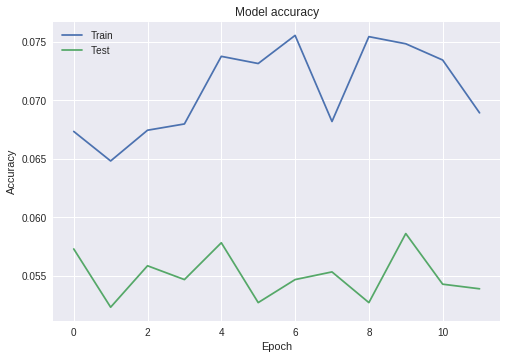

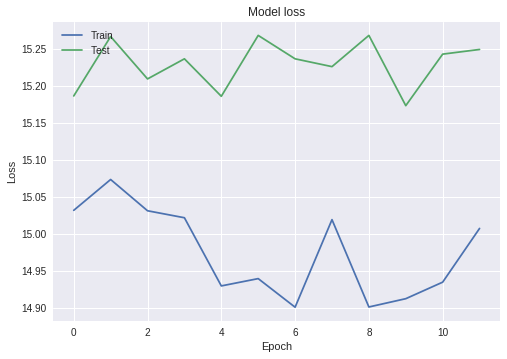

In [185]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow(x_test,y_test)
history = model.fit_generator(datagen.flow(X_train, y_train),
                    
                    steps_per_epoch=len(X_train) / 64, epochs=epochs,
                                validation_data=validation_generator,
        validation_steps=80)


plot_history(history)


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1644063023876894508, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12567550679263706002
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5707053670130073214
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276822119
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7540789445114034281
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)


In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [0]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


# Ahora con **GPU** 


In [0]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from timeit import default_timer as timer
from keras.preprocessing import image
import numpy as np
import os
image_height = 128
image_width = 128

In [0]:
# Initialising the CNN
predator = Sequential()
# Step 1 - Convolution
predator.add(Conv2D(64, (3, 3), activation="relu", input_shape=(image_height, image_width, 3)))
# Step 2 - Pooling
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
predator.add(Conv2D(256, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fourth convolutional layer
predator.add(Conv2D(128, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a fifth convolutional layer
predator.add(Conv2D(64, (3, 3), activation="relu"))
predator.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
predator.add(Flatten())    #flattens the 3D image array to a single row array
# Step 4 - Full connection
predator.add(Dense(units=32, activation="relu"))
predator.add(Dense(units=47, activation="softmax"))   #output layer with 10 neurons.. each corresponding to a character
# Compiling the CNN
predator.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [66]:
from google.colab import drive
drive.mount('/content/drive')

path = os.path.join('/root/.keras/datasets/simpsons')
for file in os.listdir(path):
            print(file)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#ImageDataGenerator augments images, creating multiple versions of the same image
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/root/.keras/datasets/simpsons',
                                                 target_size = (image_height, image_width),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/root/.keras/datasets/simpsons_testset',
                                            target_size = (image_height, image_width),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
milhouse_van_houten
troy_mcclure
agnes_skinner
lisa_simpson
marge_simpson
sideshow_bob
rainier_wolfcastle
jimbo_jones
bart_simpson
carl_carlson
fat_tony
chief_wiggum
sideshow_mel
nelson_muntz
snake_jailbird
abraham_grampa_simpson
gil
martin_prince
helen_lovejoy
patty_bouvier
krusty_the_clown
cletus_spuckler
waylon_smithers
bumblebee_man
otto_mann
mayor_quimby
selma_bouvier
ned_flanders
comic_book_guy
principal_skinner
ralph_wiggum
moe_szyslak
maggie_simpson
mi

In [0]:
predator.fit_generator(training_set,
                         steps_per_epoch = 16,
                         epochs = 100,
                         validation_data = test_set,
                         validation_steps = 4)

Epoch 1/100
16/16 [==============================] - 2s 102ms/step - loss: 0.9841 - acc: 0.7375
Epoch 2/100
16/16 [==============================] - 2s 114ms/step - loss: 1.1099 - acc: 0.7250
Epoch 3/100
16/16 [==============================] - 2s 116ms/step - loss: 0.7180 - acc: 0.7875
Epoch 4/100
16/16 [==============================] - 2s 114ms/step - loss: 0.7036 - acc: 0.8188
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.7525 - acc: 0.7812
Epoch 6/100
16/16 [==============================] - 2s 113ms/step - loss: 0.8560 - acc: 0.7625
Epoch 7/100
16/16 [==============================] - 2s 115ms/step - loss: 1.0388 - acc: 0.7000
Epoch 8/100
16/16 [==============================] - 2s 113ms/step - loss: 0.7940 - acc: 0.7938
Epoch 9/100
16/16 [==============================] - 2s 116ms/step - loss: 0.9958 - acc: 0.7063
Epoch 10/100
16/16 [==============================] - 2s 116ms/step - loss: 0.9007 - acc: 0.7750
Epoch 11/100
16/16 [===================

El tiempo de entrenamiento se reduce drasticamente cuando se utiliza GPU. En el entrenamiento con CPU  ha tardado al menos una hora. Mientras  que con GPU se ha realizado en minutos.


**4 (0.5 puntos): Utilización de tf.data**. Si no se ha entrenado el modelo en el paso 2 con tf.data, repetir la ingesta de datos (incluyendo el preprocesamiento de imágenes) para el modelo utilizando tf.data.

**5 [optativo] (1 punto extra). Implementar el modelo en TensorFlow Eager o TF de bajo nivel, sin usar tf.keras.** El bucle de entrenamiento batch a batch también tiene que hacerse utilizando operaciones de bajo nivel. En resumen, no vale utilizar capas de Keras como convoluciones o Dense ni funciones como .fit(), hay que implementarlas. Podéis programar el modelo sin embargo utilizando Keras subclassing (tf.keras.Model).

**6 [optativo] (0.5 puntos extra). Utilizar data augmentation.** Utilizar la técnica de data augmentation y comentar los resultados. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras o con tf.data.


Notas: 
* Recuerda que suele ser útil partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para su análisis. Sin embargo, recordar que **se debe mostrar el entrenamiento completo del modelo final obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas (píxeles de 0 a 255 tienen que ir a un número real entre 0 y 1).
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que lo que vemos en el validation set de nuestro modelo.
* No es necesario probar modelos tan grandes que tarden horas en entrenar. Es posible alcanzar la accuracy requerida con modelos que entrenan rápido en GPUs.
* Ojo: los datos devueltos por las funciones *load_train_set* y *load_test_set* están ordenados personaje a personaje.

18992 train samples
890 test samples
(18992, 64, 64, 3)
(18992, 64, 64, 3)


In [0]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(12288,)))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 4096)              50335744  
_________________________________________________________________
dropout_41 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_42 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 47)                192559    
Total params: 67,309,615
Trainable params: 67,309,615
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: ignored